In [1]:
import numpy as np
from numpy import linalg as LA

import cvxpy
import optim_tools #own file with helper

import matplotlib.pyplot as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
print cvxpy.installed_solvers()

['CVXOPT', 'MOSEK', 'ECOS_BB', 'GLPK_MI', 'SCS', 'ECOS', 'GLPK', 'LS']


In [3]:
#################################
# Roboter pt2+pos (ohne delay)  #
# Position output               #
#################################

A0 = np.matrix([[ 0,  0.,         -10],
               [ 0,  0.,         -55.99932527],
               [ 0, 10.,         -43.64272128]])

b0 = np.matrix([[0],
               [-5.58731344],
               [ 0.        ]])

c0 = np.matrix([ 1., 0.,  0.])
              
d0 = np.matrix([0])
u_max = 2.0
U_max = [u_max]

#n = len(b)

delay = 0.032

X00 = [np.matrix([ 1.0, -0.5, -0.025]).T,
       np.matrix([ 1.0, -0.5,  0.025]).T,
       np.matrix([ 1.0,  0.5, -0.025]).T,
       np.matrix([ 1.0,  0.5,  0.025]).T,
       np.matrix([ -1.0, -0.5, -0.025]).T,
       np.matrix([ -1.0, -0.5,  0.025]).T,
       np.matrix([ -1.0,  0.5, -0.025]).T,
       np.matrix([ -1.0,  0.5,  0.025]).T,

      ]

X0 = X00

#plt.plot(*pc.step_response(pc.ss(A0, b0, c0, d0)))


In [4]:
###########################
# another set of          #
# Roboter pt2d + pos      #
###########################

A = np.matrix([[ 0., 0.,  0.,   -1.       ],
               [ 0., 0.,  0,    22.7272727],
               [ 0., 10,  0,    24.4318182],
               [ 0., 0, -100, -86.3636364]])

B = np.matrix([[0],
               [22.72727273],
               [-6.25      ],
               [ 0.        ]])

C = np.matrix([[ 1.,  0., 0., 0.]])

D = np.matrix([[ 0. ]])

u_max = 2.0
U_max = [u_max]

n = len(B)

X00 = [np.matrix([1.0, 1.0,  -0.5, -0.025]).T,
         np.matrix([1.0, 1.0,  -0.5,  0.025]).T,
         np.matrix([1.0, 1.0,   0.5, -0.025]).T,
         np.matrix([1.0, 1.0,   0.5,  0.025]).T,
         np.matrix([1.0, -1.0, -0.5, -0.025]).T,
         np.matrix([1.0, -1.0, -0.5,  0.025]).T,
         np.matrix([1.0, -1.0,  0.5, -0.025]).T,
         np.matrix([1.0, -1.0,  0.5,  0.025]).T,
        np.matrix([-1.0, 1.0,  -0.5, -0.025]).T,
         np.matrix([-1.0, 1.0,  -0.5,  0.025]).T,
         np.matrix([-1.0, 1.0,   0.5, -0.025]).T,
         np.matrix([-1.0, 1.0,   0.5,  0.025]).T,
         np.matrix([-1.0, -1.0, -0.5, -0.025]).T,
         np.matrix([-1.0, -1.0, -0.5,  0.025]).T,
         np.matrix([-1.0, -1.0,  0.5, -0.025]).T,
         np.matrix([-1.0, -1.0,  0.5,  0.025]).T,
      ]

X0 = X00

#plt.plot(*pc.step_response(pc.ss(A, b, c, d)))
print pc.pole(pc.ss(A, B, C, D))
print pc.zero(pc.ss(A, B, C, D))

[  0.         -24.99790258 -25.00209781 -36.36363601]
[-1.48291074e+08  1.48291006e+08  3.63636364e+01]


In [5]:
## Helper functions for optimization problem

def Tri(i, n_u):
    if n_u>1:
        print "not implemented"
        print "alle permutationen mit einsen auf der hauptdiagonalen!"
        raise Error()
        
    if i==1:
        return np.eye(n_u)
    else:
        # only true for n_u == 1
        return np.zeros((n_u, n_u))

def negTri(i, n_u):
    return np.eye(n_u) - Tri(i, n_u)


In [6]:
%%time
# Satz 6.6

# Init
n = B.shape[0] # get dim of system
n_u = B.shape[1] 

# Variables
X = cvxpy.Semidef(n)
Y = cvxpy.Semidef(n)
W = cvxpy.Variable(n_u)

Ak_h = cvxpy.Semidef(*A.shape)
Bk_h = cvxpy.Variable(*B.shape)
Ck_h = cvxpy.Variable(*C.shape)
Dk_h = cvxpy.Variable(*D.shape)

Ch = cvxpy.Variable(*C.shape)
Dh = cvxpy.Variable(*D.shape)

# Substitutionen
C_hat = lambda i: Tri(i, n_u)*Ck_h + negTri(i, n_u)*Ch
D_hat = lambda i: Tri(i, n_u)*Dk_h + negTri(i, n_u)*Dh

Xi = cvxpy.bmat([[ A*X + B*Ck_h, A + B*Dk_h*C ],
                 [ Ak_h,         Y*A + Bk_h*C ]])

I = np.eye(n)

# Bisection parameter
g = cvxpy.Parameter(sign='positive')

# Pole restriction
ro = cvxpy.Parameter(sign='positive') # Real <=-ro
ni = cvxpy.Parameter(sign='positive') # |Imag| <= ni*Real

ro.value = 100
ni.value = 1

# Define Constraints

# (6.39a)
const_639a = cvxpy.bmat([[X, I],
                         [I, Y]]) >> 0
                         #[I, Y]]) == cvxpy.Semidef(2*n)



# (6.39b)
const_639b = cvxpy.bmat([[ X*A.T + A*X + B*Ck_h + (B*Ck_h).T, Ak_h.T + A + B*Dk_h*C            ],
                         [ cvxpy.Variable(n, n),          A.T*Y + Y*A + Bk_h*C + (Bk_h*C).T]]) + \
             2*g*cvxpy.bmat([[X, I],
                             [I, Y]]) << 0
                             #[I, Y]]) == -cvxpy.Semidef(2*n)
    
# (6.39c)
const_639c = [cvxpy.bmat([[ X*A.T + A*X + B*C_hat(i) + (B*C_hat(i)).T, Ak_h.T + A + B*D_hat(i)*C            ],
                          #[ cvxpy.Variable(n, n),                      A.T*Y + Y*A + Bk_h*C + (Bk_h*C).T]]) << 0 for i in range(2, (2**n_u)+1)]
                          [ cvxpy.Variable(n, n),                      A.T*Y + Y*A + Bk_h*C + (Bk_h*C).T]]) == -cvxpy.Semidef(2*n) for i in range(2, (2**n_u)+1)]
    
    
# (6.39d)
const_639d = cvxpy.bmat([[ X,  I,    Ch.T     ],
                         [ I,  Y,    (Dh*C).T ],
                         [ Ch, Dh*C, W        ]]) >> 0
                         #[ Ch, Dh*C, W        ]]) == cvxpy.Semidef(2*n+n_u)

const_639e = [W[j,j] <= U_max[j]**2 for j in range(0, n_u)]

const_639f = [ X0[k].T*Y*X0[k] <= 1.0
                            for k in range(0, len(X0))]

const_621a = Xi.T + Xi + ro*cvxpy.bmat([[X, I],
                                        [I, Y]]) >> 0
                                        #[I, Y]]) == cvxpy.Semidef(2*n)

const_621b = cvxpy.bmat([[ ni*(Xi.T + Xi), Xi.T - Xi ],
                         [ -Xi.T + Xi,     ni*(Xi.T + Xi) ]]) << 0
                         #[ -Xi.T + Xi,     ni*(Xi.T + Xi) ]]) == -cvxpy.Semidef(4*n)

# Collect all constraints
constraints_639 = []
constraints_639.append(const_639a)
constraints_639.append(const_639b)
constraints_639.extend(const_639c)
constraints_639.append(const_639d)
constraints_639.extend(const_639e)
constraints_639.extend(const_639f)

constraints_639.append(const_621a)
constraints_639.append(const_621b)


# Form problem.
prob_66 = cvxpy.Problem(cvxpy.Minimize(0), constraints_639)

# bisection with one solver
#[[X_o, Y_o, W_o,
#  Ak_h_o, Bk_h_o, Ck_h_o, Dk_h_o,
#  Ch_o, Dh_o], g_o] = optim_tools.bisect_max(0, None, prob_66, g, [X, Y, W, Ak_h, Bk_h, Ck_h, Dk_h, Ch, Dh], bisect_verbose=True,
#                                                      bisection_tol=0.01,
#                                                      #solver=cvxpy.CVXOPT, verbose=False,  max_iters=50000)
#                                                      solver=cvxpy.MOSEK, verbose=False)
#                                                      #solver=cvxpy.SCS, max_iters=50000)

# bisection alternative with list of multiple solvers
[[X_o, Y_o, W_o,
  Ak_h_o, Bk_h_o, Ck_h_o, Dk_h_o,
  Ch_o, Dh_o], g_o] = optim_tools.bisect_max2(0, None, prob_66, g, [X, Y, W, Ak_h, Bk_h, Ck_h, Dk_h, Ch, Dh],
                                                      bisect_verbose=True,
                                                      bisection_tol=0.01,
                                                      solvers=[
                                                               (cvxpy.CVXOPT, {'verbose':False}),
                                                               (cvxpy.MOSEK, {'verbose':False}),
                                                               #(cvxpy.SCS, {'max_iters':5000, 'warm_start':True, 'verbose':True})
                                                              ])
print "g:", g_o

print
print '-----------------------'

processing upper bound: 1.0
processing upper bound: 2.0
processing upper bound: 4.0
processing upper bound: 8.0
processing upper bound: 16.0
processing upper bound: 32.0
 -----> Exception by CVXOPT: Solver 'CVXOPT' failed. Try another solver.
found bounds: [16.0-32.0]
 -----> Exception by CVXOPT: Solver 'CVXOPT' failed. Try another solver.
 -----> Exception by CVXOPT: Solver 'CVXOPT' failed. Try another solver.
 -----> Exception by MOSEK: Solver 'MOSEK' failed. Try another solver.
Range: 16.0-32.0; parameter 24.0 -> unknown
 -----> Exception by CVXOPT: Solver 'CVXOPT' failed. Try another solver.
 -----> Exception by MOSEK: Solver 'MOSEK' failed. Try another solver.
Range: 16.0-24.0; parameter 20.0 -> unknown
Range: 16.0-20.0; parameter 18.0 -> optimal
Range: 18.0-20.0; parameter 19.0 -> optimal
 -----> Exception by CVXOPT: Solver 'CVXOPT' failed. Try another solver.
 -----> Exception by MOSEK: Solver 'MOSEK' failed. Try another solver.
Range: 19.0-20.0; parameter 19.5 -> unknown
Range:

In [7]:
# QR Decomposition for M and N
M, NT = LA.qr(I - X_o.dot(Y_o))
N = NT.T
#assert(np.allclose(I - X_o.dot(Y_o), M.dot(N.T)))

# Reconstruction
Ek = -LA.solve(N, Y_o.dot(B))
Dk = np.matrix(Dk_h_o)

Ck = LA.solve(M, (Ck_h_o - Dk.dot(C).dot(X_o)).T).T
#Ck_1 = (Ck_h_o - Dk.dot(C).dot(X_o)).dot(LA.inv(M).T) #Check
#assert(np.allclose(Ck_1, Ck))

Bk = LA.solve(N, Bk_h_o)

temp_alpha = LA.solve(N, (Ak_h_o-Y_o.dot(A).dot(X_o)))
temp_beta = Bk.dot(C).dot(X_o)
Ak = (LA.solve(M, temp_alpha.T) - LA.solve(M, temp_beta.T)).T

#Ak_1 = LA.solve(N, (Ak_h_o-Y_o.dot(A).dot(X_o))).dot(LA.inv(M).T) - Bk.dot(C).dot(X_o).dot(LA.inv(M).T) #Check
#assert(np.allclose(Ak_1, Ak))


In [8]:
#np.set_printoptions(formatter={"float_kind": lambda x: "%g" % x})
#np.set_printoptions(precision=4)
np.set_printoptions(suppress=True,
   formatter={'float_kind':'{:16.3f}'.format}, linewidth=130)

print Ak
print Bk
print Ck
print Dk
print Ek
print u_max
#print dT
print
print A
print B
print C
print D

[[         -43.930           -2.226           -0.371            0.000]
 [         -43.035          -29.935           -2.876           -0.001]
 [          90.905            3.042          -36.901           -0.003]
 [     -489300.878       -22103.776        -6211.063          -29.036]]
[[          -0.001]
 [          -0.002]
 [           0.001]
 [         -13.592]]
[[    -1517133.996       -70778.353       -19135.363           36.473]]
[[         -42.109]]
[[           0.000]
 [          -0.002]
 [           0.005]
 [          -0.412]]
2.0

[[           0.000            0.000            0.000           -1.000]
 [           0.000            0.000            0.000           22.727]
 [           0.000           10.000            0.000           24.432]
 [           0.000            0.000         -100.000          -86.364]]
[[           0.000]
 [          22.727]
 [          -6.250]
 [           0.000]]
[[           1.000            0.000            0.000            0.000]]
[[           0.00

In [9]:
from numpy.linalg import solve, inv

#def control_func(y, s, x, k, A, b, c):
#    N = -c.dot(solve(A-b.dot(k.T), b))
#    u = solve(N, np.array([s]))-k.T.dot(x)
#    return u

class control_func_dyn_out():
    def __init__(self, Ak, Bk, Ck, Dk, Ek, A, B, C, D, umax=None, dT=1e-3):
        self.Ak = Ak
        self.Bk = Bk
        self.Ck = Ck
        self.Dk = Dk
        self.Ek = Ek
        self.umax = umax
        self.dT = dT

        self.z = np.zeros(B.shape)
                
        # Construct Prefilter
        C2 = np.hstack((-C, np.zeros(Ck.shape)))

        A2_u = np.hstack(((A+B.dot(Dk).dot(C)), B.dot(Ck)))
        A2_d = np.hstack((Bk.dot(C), Ak))

        A2 = np.vstack((A2_u, A2_d))
        B2 = np.vstack((B, np.zeros(Bk.shape)))

        self.N = inv(C2.dot(inv(A2)).dot(B2))
        #print self.N
        
    def estimate(self, y, u):
        # already saturated in this case
        #if self.umax is not None:
        #    u = optim_tools.sat(u, self.umax)
        
        z_dot = self.Ak.dot(self.z) + self.Bk.dot(y) + self.Ek.dot(u)
        return self.z + z_dot*self.dT
        
    def regulate(self, y, s, x):
        u = self.N.dot(s)+self.Ck.dot(self.z) + self.Dk.dot(y)

        # Saturate 
        if self.umax is not None:
            u = optim_tools.sat(u, self.umax)
            
        self.z = self.estimate(y, u)
        return u

In [10]:
# Timeline
T = np.arange(0, 1, 1e-3) 

#s: input, e.g., step function with amplitude of 0.2
#s = np.zeros(len(T));
s = np.ones(len(T));


# Initial state
x0 = np.zeros(B.shape)

In [11]:
from functools import partial

y0, u0, u0_sat = optim_tools.simulate(A, B, C, D, 
                                   partial(optim_tools.openLoop),
                                   s, T, delay=None, umax=u_max, x0=x0)

y1, u1, u1_sat = optim_tools.simulate(A, B, C, D, 
                                   control_func_dyn_out(Ak, Bk, Ck, Dk, Ek,
                                                        A, B, C, D,
                                                        umax=u_max).regulate,
                                   s, T, delay=None, umax=u_max, x0=x0)


In [12]:
y2, u2, u2_sat = optim_tools.simulate(A0, b0, c0, d0, 
                                   control_func_dyn_out(Ak, Bk, Ck, Dk, Ek,
                                                        A, B, C, D,
                                                        umax=u_max).regulate,
                                   s, T, delay=delay, umax=u_max, x0=np.zeros(b0.shape))


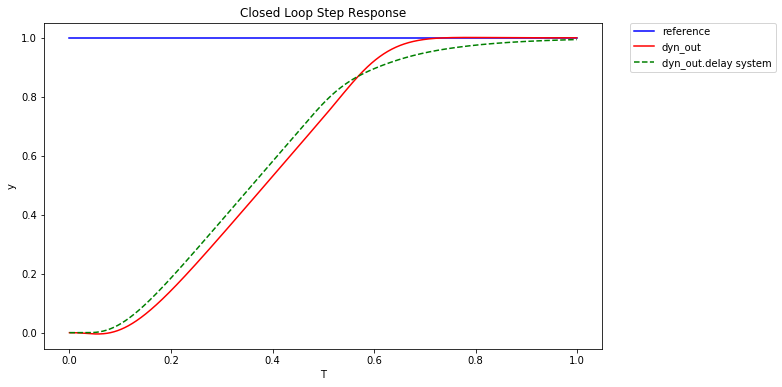

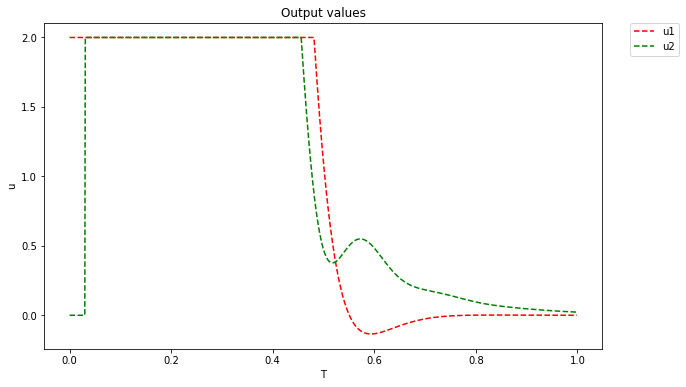

In [13]:
pylab.rcParams['figure.figsize'] = (10, 6)

line_s, = plt.plot(T[:], s, 'b', label='reference')
line0, = plt.plot(T[:], np.array(y1[0,:].T), 'r', label='dyn_out')
line1, = plt.plot(T[:], np.array(y2[0,:].T), 'g--', label='dyn_out.delay system')


#first_legend = plt.legend(handles=[line1], loc=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('T')
plt.ylabel('y')
plt.title('Closed Loop Step Response')
plt.show()


line0, = plt.plot(T, u1, 'r--', label='u1')
line2, = plt.plot(T, u2, 'g--', label='u2')



#>first_legend = plt.legend(handles=[line1, line2, line1b, line2b], loc=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('T')
plt.ylabel('u')
plt.title('Output values')
plt.show()
